In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt
import statistics as stat
import csv
import talib

## 1.  資料匯入

In [2]:
data = pd.read_csv("data_adjclose.csv", index_col=0 )
data.index = pd.to_datetime(data.index)
tickers = [i for i in data]
data.head()

,VTI,VGK,VPL,VWO,PFF,IEI,BWX,AGG,BND,FXY,FXF,UDN,IAU,AOA,AOK,USO
Date,,,,,,,,,,,,,,,,
2014-01-02,84.378860,46.217941,51.057976,33.389236,25.745323,108.694878,27.300598,90.548790,67.201050,93.250000,108.667809,26.176607,11.88,37.321964,27.329165,273.839996
2014-01-03,84.361145,46.225983,51.244526,33.347179,25.898182,108.613411,27.233980,90.582863,67.209480,93.220001,108.008736,26.050152,12.01,37.347317,27.380636,270.000000
2014-01-06,84.139259,46.266125,51.032539,33.027584,26.051073,108.785301,27.352930,90.701874,67.268166,93.779999,108.208450,26.137697,12.01,37.296593,27.346323,268.559998
2014-01-07,84.680595,46.579334,51.185162,33.162144,26.002424,108.875786,27.371956,90.744354,67.352066,93.419998,107.549370,26.079332,11.95,37.465664,27.432093,268.640015
2014-01-08,84.742729,46.555244,51.261486,33.103275,26.044107,108.468697,27.272049,90.472290,67.133980,93.250000,107.409569,26.020967,11.89,37.448750,27.397795,265.279999


In [3]:
returns = (data - data.shift(1)) / data.shift(1)

## 2. 兩種觀點下的long-short portfolio

### 技術指標1：KD值

In [4]:
from talib import abstract
#匯入最高價、最低價、收盤價(未調整)資料
high = pd.read_csv("data_high.csv", index_col=0 )
high.index = pd.to_datetime(high.index)

low = pd.read_csv("data_low.csv", index_col=0 )
low.index = pd.to_datetime(low.index)

close = pd.read_csv("data_close.csv", index_col=0 )
close.index = pd.to_datetime(close.index)

<b> (1) 計算KD值

In [5]:
def etf2pd(etf):
    etf_pd = pd.DataFrame(index=data.index)
    etf_pd["high"] = high[etf]
    etf_pd["low"] = low[etf]
    etf_pd["close"] = close[etf]
    return etf_pd

In [6]:
#K-D>0:買進；K-D<0:賣出
kd = pd.DataFrame()
for i in tickers:
    tmp_kd = abstract.STOCH(etf2pd(i), fastk_period=9, slowk_period=3,slowd_period=3).fillna(value=0).asfreq("BM")
    comp_kd = tmp_kd["slowk"] - tmp_kd["slowd"]   #series
    kd[i] = comp_kd

kd.head()

,VTI,VGK,VPL,VWO,PFF,IEI,BWX,AGG,BND,FXY,FXF,UDN,IAU,AOA,AOK,USO
Date,,,,,,,,,,,,,,,,
2014-01-31,-0.373405,-4.488967,-1.558912,-0.273394,8.108870,4.734404,-6.240443,6.611788,4.731743,1.876289,-15.047688,-24.857753,-11.111142,-1.024270,0.231531,-0.569352
2014-02-28,2.386223,-1.898027,-1.829584,5.207537,3.566856,8.161874,3.373307,5.773956,4.646533,11.068509,-2.339315,0.128231,-14.478681,2.319607,1.847188,-2.350346
2014-03-31,12.747101,15.961315,8.716466,1.808538,0.514737,-1.511757,-0.088840,3.886334,2.368098,-11.905247,-1.168874,-5.285479,0.457240,11.851646,13.777500,0.401607
2014-04-30,1.588648,3.886991,-6.688849,6.452840,1.286832,16.452395,8.217681,9.046464,7.844880,2.989304,5.062615,7.175798,3.987554,3.378424,1.542213,1.045620
2014-05-30,-0.198858,4.226532,0.034360,-12.878495,11.366503,-11.109611,4.261365,-0.082890,-6.337857,4.958068,6.990604,0.926050,-0.830660,-2.546350,-11.685799,-13.322157


<b> (2) 定義函數：抓每個月KD前四和後四檔的ETF

In [7]:
def get_8_etf_kd(time):   #time: "y-m" ex."2005-1"   #output: 兩個list(long, short)
    temp_kd_set = kd[time]   #type: pd.dataframe
    monthly_kd_set = []   #每個月的etf排名及其kd值
    for j in range(temp_kd_set.shape[1]):   #df行數
        etf_kd = [tickers[j], temp_kd_set.iloc[0, j]]
        monthly_kd_set.append(etf_kd)
    monthly_kd_set.sort(key=lambda x: x[1], reverse=True)
    #print(monthly_kd_set)
    #取出每月前四檔和後四檔etf名稱
    long_4_etf = [k[0] for k in monthly_kd_set[:4]]
    short_4_etf = [l[0] for l in monthly_kd_set[-4:]]
    return long_4_etf, short_4_etf

<b> (3) 使用函數跑每月的權重與最終整體報酬率（period: 2014/1~2016/12)

In [8]:
weight_kd = pd.DataFrame(columns=tickers,index=kd.index).fillna(value=0)

for y in range(2014, 2017):   #2014/1~2016/12
    for m in range(1, 13):
        time = str(y)+'-'+str(m)
        #print(time)
        tmp_etf = get_8_etf_kd(time)
        for a in tmp_etf[0]:
            weight_kd.loc[time, a] = 0.25
        for b in tmp_etf[1]:
            weight_kd.loc[time, b] = -0.25

In [9]:
q_kd = []    #q1~q95
tmp_weight_kd = weight_kd.shift(1) #把前個月的權重換成下個月index，使ret_次月和weight_這個月配在一起
for y in range(2014, 2017):
    for m in range(1, 13):
        time = str(y)+'-'+str(m)   #這個月
        #print(time)
        if time != '2014-1':
            tmp_ret = returns[time].mean()    #series   #若沒有取mean,則為dataframe
            monthly_q_kd = float(tmp_weight_kd[time].dot(tmp_ret).to_numpy())
            q_kd.append(monthly_q_kd)
        else:
            pass
#print(len(q_kd))
print('KD mean:', stat.mean(q_kd))

KD mean: -0.00044436467789216524


<b/> ➤以KD作為投資組合選擇指標建構long-short portfolio，則平均報酬率為-0.0444%。

### 技術指標2：指數移動平均線 EMA

<b> (1) 計算每日20日(短線)與35日(長線)的EMA差值，取每月月底MA數值作為預測。

In [10]:
ma = pd.DataFrame()
for i in tickers:
    ma[i] = talib.EMA(data[i], timeperiod=20) - talib.EMA(data[i], timeperiod=35)
monthly_ma = ma.asfreq("BM")

若為正數，即表示當日短均線超過長均線，為看漲的股票；反之則看跌。

<b> (2) 同上步驟，抓出每月long-short portfolio的資產分配權重，並試算出2014~2016年的整體報酬率。

In [11]:
def get_8_etf_ma(time):   #time: "y-m" ex."2014-1"   #output: 兩個list(long, short)
    temp_ma_set = monthly_ma[time]   #type: pd.dataframe
    monthly_ma_set = []   #每個月的etf排名及其ma值
    for j in range(temp_ma_set.shape[1]):   #df行數
        etf_ma = [tickers[j], temp_ma_set.iloc[0, j]]   #ix: label or index searching
        monthly_ma_set.append(etf_ma)
    monthly_ma_set.sort(key=lambda x: x[1], reverse=True)
    #取出每月前四檔和後四檔etf名稱
    long_4_etf = [k[0] for k in monthly_ma_set[:4]]
    short_4_etf = [l[0] for l in monthly_ma_set[-4:]]
    return long_4_etf, short_4_etf

In [12]:
weight_ma = pd.DataFrame(columns=tickers,index=pd.date_range('2014/1/1','2019/4/30', freq='BM')).fillna(value=0)

for y in range(2014, 2017):
    for m in range(1, 13):
        time = str(y)+'-'+str(m)
        #print(time)
        tmp_etf = get_8_etf_ma(time)
        for a in tmp_etf[0]:
            weight_ma.loc[time, a] = 0.25
        for b in tmp_etf[1]:
            weight_ma.loc[time, b] = -0.25

In [13]:
q_ma = []    #q1~q36
tmp_weight_ma = weight_ma.shift(1)
for y in range(2014, 2017):
    for m in range(1, 13):
        time = str(y)+'-'+str(m)   #這個月
        #print(time)
        if time != '2014-1':
            tmp_ret = returns[time].mean()    #series   #若沒有取mean,則為dataframe
            monthly_q_ma = float(tmp_weight_ma[time].dot(tmp_ret).to_numpy())
            q_ma.append(monthly_q_ma)
        else:
            pass

print('EMA mean:', stat.mean(q_ma))

EMA mean: 0.00031016332840625154


<b/> ➤以EMA作為投資組合選擇的指標，則平均報酬率為0.0310%。

### 合併兩種view的估計資料

In [14]:
Q = np.array([
    [stat.mean(q_kd)],
    [stat.mean(q_ma)]
])
Q

array([[-0.00044436],
       [ 0.00031016]])

In [15]:
omega = np.cov(np.stack((q_kd, q_ma), axis = 0)  )
print(omega) 

[[ 2.03565566e-06 -3.90139048e-07]
 [-3.90139048e-07  3.07498364e-06]]


## 3. 代入Blacklitterman Model (period2： 2017/1/2 ~ 2019/4/30)

<b> (1) 以KD與EMA作為技術指標，預測第二期的long-short portfolio權重

In [16]:
asset_value = [860690000000, 15350000000, 5850000000, 74430000000, 15370000000, 12160000000, 786970000,
              72640000000, 269050000000, 237470000, 238750000, 36110000, 24550000000, 957340000, 680370000, 8400000000]
total_value = sum(asset_value)
w_eq = [(i/total_value) for i in asset_value]

In [17]:
#每個月一個共變數矩陣sigma
tau = 0.05
delta = 3  #風險趨避係數
omega_inv = np.linalg.inv(omega)

In [18]:
#第二段區間的時間(2017/1~2019/4)
period_2 = []
for y in range(2017, 2019):
    for m in range(1, 13):
        time = str(y)+'-'+str(m)
        period_2.append(time)

for m in range(1, 5):
    time = '2019-'+str(m)
    period_2.append(time)

In [19]:
for time in period_2:
    tmp_etf = get_8_etf_kd(time)
    for a in tmp_etf[0]:
        weight_kd.loc[time, a] = 0.25
    for b in tmp_etf[1]:
        weight_kd.loc[time, b] = -0.25

In [20]:
for time in period_2:
    tmp_etf = get_8_etf_ma(time)
    for a in tmp_etf[0]:
        weight_ma.loc[time, a] = 0.25
    for b in tmp_etf[1]:
        weight_ma.loc[time, b] = -0.25

<b> (2) 代入Blacklitterman Model進行觀點調整，試算出每月最佳權重w*

In [21]:
# 每個月的P矩陣(技術指標權重)
def get_p_matrix(time):
    view1 = weight_kd[time].values.tolist()[0]
    view2 = weight_ma[time].values.tolist()[0]
    p = np.stack([view1, view2])   #matrix:2x19，type:ndarray
    return p  

In [22]:
def get_optimal_weight(time):
    P = get_p_matrix(time)
    sigma = returns[time].cov()
    A = omega/tau + (P.dot(sigma).dot(np.transpose(P))/(1+tau))
    A_inv = np.linalg.inv(A)   #反矩陣
    lmda = (omega_inv.dot(Q)*tau/delta) - A_inv.dot(P).dot((sigma/(1+tau))).dot(np.transpose(w_eq)) \
    - (A_inv.dot(P).dot((sigma/(1+tau))).dot(np.transpose(P)).dot(omega_inv).dot(Q))*(tau/delta)
    optimal_w = (1/(1+tau))*(w_eq + np.transpose(np.transpose(P).dot(lmda)))
    return optimal_w

In [23]:
# BL模型的optimal weight
w_bl = pd.DataFrame(columns=tickers,index=pd.date_range('2017/1/1','2019/4/30', freq='BM'))
for time in period_2:
    opt_w = [get_optimal_weight(time)[0]]
    #print(len(opt_w))
    w_bl[time] = opt_w

w_bl.head()

,VTI,VGK,VPL,VWO,PFF,IEI,BWX,AGG,BND,FXY,FXF,UDN,IAU,AOA,AOK,USO
2017-01-31,1.13938,0.548025,0.541379,0.0520672,0.010752,-0.52878,-0.0934079,-0.486472,-0.255116,-0.0937923,0.000167017,2.52606e-05,-0.426155,0.443998,0.00047595,0.0998346
2017-02-28,0.729101,0.520747,0.64111,0.689085,-0.499257,-0.118502,-0.636467,0.050815,0.188213,0.000166121,-0.63685,-0.636992,0.0171739,0.637687,0.00047595,0.00587619
2017-03-31,0.265172,0.184969,0.178324,0.73745,0.010752,-0.502645,0.511702,0.050815,0.0139816,0.000166121,0.511319,0.336946,-0.157057,-0.510482,0.00047595,-0.679507
2017-04-28,1.48334,0.241548,0.00409234,0.0520672,0.010752,-0.41112,0.650987,-0.599622,-0.462224,0.230976,0.419794,0.419652,-0.213636,0.000669703,-0.649961,-0.224934
2017-05-31,0.859971,0.716552,0.261971,0.0520672,0.200808,-0.439428,0.000550522,-0.39712,-0.259722,-0.705648,0.258046,0.44796,-0.240705,0.000669703,0.00047595,0.195932


## 4. 模型投資組合績效比較

<b> (1) 投資組合報酬率比較

個別ETF報酬率比較：BL Model v.s. Equilibrium

In [24]:
# BL Model各資產每月報酬率
returns_bl = pd.DataFrame(columns=tickers,index=pd.date_range('2017/1/1','2019/4/30', freq='BM'))
for time in period_2:
    r = np.array(returns[time].mean().values)
    w = w_bl[time].values
    tmp_ret_bl = r * w
    returns_bl[time] = tmp_ret_bl
        
returns_bl.head()

,VTI,VGK,VPL,VWO,PFF,IEI,BWX,AGG,BND,FXY,FXF,UDN,IAU,AOA,AOK,USO
2017-01-31,0.00105927,0.000807896,0.00131081,0.000146803,1.28173e-05,-7.86941e-05,-6.97556e-05,-5.29089e-05,-2.43948e-05,-0.000165607,2.33045e-07,3.33023e-08,-0.00111801,0.000449557,1.4706e-07,-0.000160724
2017-02-28,0.00139719,0.000164479,0.000722239,0.000816815,-0.000543935,-1.64875e-05,-0.000105127,1.73047e-05,6.12313e-05,4.31191e-08,0.000514299,0.000496136,2.84689e-05,0.000808214,3.80329e-07,3.83582e-06
2017-03-31,1.00527e-05,0.000352056,0.000141377,0.000932297,2.37605e-06,-2.44264e-05,0.000175263,-1.09286e-06,-2.03556e-07,6.19104e-08,4.61914e-05,8.81096e-05,1.38125e-05,-0.000267937,1.17617e-07,0.00207746
2017-04-28,0.000842477,0.000496769,1.67759e-06,4.34546e-05,7.34747e-06,-0.000143532,0.00048899,-0.000286171,-0.00019375,-1.54165e-05,0.000119803,0.000308385,-0.000189241,5.51171e-07,-0.000374903,0.000434322
2017-05-31,0.000403784,0.00158069,0.000261951,2.52028e-05,5.06625e-05,-8.72587e-05,4.81596e-07,-0.000124217,-8.39314e-05,-0.000200189,0.000308733,0.000394891,2.82745e-06,5.53448e-07,2.42348e-07,-0.000202928


In [25]:
# Equilibrium 各資產每月報酬率
returns_eq = pd.DataFrame(columns=tickers,index=pd.date_range('2017/1/1','2019/4/30', freq='BM'))
for time in period_2:
    r = np.array(returns[time].mean().values)
    w = w_eq
    tmp_ret_eq = r * w
    #print("port ret:", tmp_ret_eq)
    returns_eq[time] = tmp_ret_eq[np.newaxis,:]    #ret[time].shape = (1,16)

returns_eq.head()

,VTI,VGK,VPL,VWO,PFF,IEI,BWX,AGG,BND,FXY,FXF,UDN,IAU,AOA,AOK,USO
2017-01-31,0.00058775,1.66215e-05,1.04039e-05,0.000154144,1.34581e-05,1.32925e-06,4.31677e-07,5.803e-06,1.88973e-05,3.07981e-07,2.44697e-07,3.49674e-08,4.73081e-05,7.11992e-07,1.54413e-07,-9.93307e-06
2017-02-28,0.00121149,3.56121e-06,4.84072e-06,6.48044e-05,1.22999e-05,1.2427e-06,9.54775e-08,1.81699e-05,6.42929e-05,4.52751e-08,-1.41621e-07,-2.06585e-08,2.98924e-05,8.91232e-07,3.99346e-07,4.02762e-06
2017-03-31,2.39667e-05,2.14598e-05,3.40669e-06,6.91155e-05,2.49485e-06,4.34047e-07,1.97987e-07,-1.1475e-06,-2.87718e-06,6.5006e-08,1.58423e-08,6.9358e-09,-1.58588e-06,3.69084e-07,1.23498e-07,-1.88636e-05
2017-04-28,0.000359062,2.31881e-05,1.76147e-06,4.56273e-05,7.71485e-06,3.11831e-06,4.34201e-07,2.54642e-05,8.28375e-05,-1.16421e-08,5.00473e-08,1.94912e-08,1.59734e-05,5.78729e-07,2.88259e-07,-1.19136e-05
2017-05-31,0.000296836,2.48722e-05,4.29663e-06,2.6463e-05,2.8483e-06,1.77362e-06,5.05676e-07,1.66893e-05,6.38637e-05,4.94841e-08,2.09815e-07,2.33814e-08,-2.1182e-07,5.8112e-07,2.54466e-07,-6.3903e-06


<b>兩投資組合每月報酬率比較

In [26]:
port_ret_bl = returns_bl.sum(axis=1)   #列加總
port_ret_eq = returns_eq.sum(axis=1)

comparison_ret = pd.DataFrame(columns=["Equilibrium", "BL Model", "Outperform"], index=pd.period_range('2017/1',freq='M', periods=28))
for time in period_2:
    comparison_ret.loc[time, "Equilibrium"] = port_ret_eq[time].values[0]   #type: ndarray
    comparison_ret.loc[time, "BL Model"] = port_ret_bl[time].values[0]
    if port_ret_eq[time].values[0] < port_ret_bl[time].values[0]:
        comparison_ret.loc[time, "Outperform"] = "Yes"
    else:
        comparison_ret.loc[time, "Outperform"] = "No"

comparison_ret.head()

,Equilibrium,BL Model,Outperform
2017-01,0.000847667,0.00211747,Yes
2017-02,0.00141589,0.00436509,Yes
2017-03,9.71818e-05,0.00354552,Yes
2017-04,0.000554193,0.00154076,Yes
2017-05,0.000432665,0.0023315,Yes


In [27]:
comparison_ret["Outperform"].value_counts()

Yes    23
No      5
Name: Outperform, dtype: int64

<b> 〈結果〉兩投資組合第二段期間的整體年報酬率比較

In [28]:
eq_ret = comparison_ret["Equilibrium"].mean()*12
bl_ret = comparison_ret["BL Model"].mean()*12
print("Equilibrium return:", eq_ret)
print("BL Model return:", bl_ret)

Equilibrium return: 0.005073918537274045
BL Model return: 0.01996998927752841


<b> (2) 投資組合波動率比較

投資組合波動率公式：var(p) = wa^2 * var(a) + wb^2 * var(b) + 2 * wa * wb * cov(a,b)
<br>matrix method： var(p) = w(1,19) * var-cov matrix(19,19) * w'(19,1)

In [29]:
volatility = pd.DataFrame(columns=tickers, index=pd.period_range('2017/1',freq='M', periods=28))
for time in period_2:
    volatility[time] = returns[time].std().values[np.newaxis, :]   #增加dim from (19,)to (1,19)

<b>兩投資組合每月波動率比較

In [30]:
#cov(assets) = sigma
comparison_vol = pd.DataFrame(columns=["Equilibrium", "BL Model", "Outperform"], index=pd.period_range('2017/1',freq='M', periods=28))
#print(comparison_vol)
for time in period_2:
    sigma = returns[time].cov()
    # variance
    tmp_bl = np.array(w_bl[time].values.dot(sigma).dot(np.transpose(w_bl[time])), dtype=np.float64)  #.values shape: (1,19) #outcome: (1,1)
    tmp_eq = np.array(w_eq).dot(sigma).dot(np.transpose(w_eq))
    #print(type(tmp_bl))
    # std
    #print(comparison_vol.ix[time,0])
    comparison_vol.loc[time, "Equilibrium"] = np.sqrt(tmp_eq)
    comparison_vol.loc[time, "BL Model"] = np.sqrt(tmp_bl)[0][0]  #float64才能使用sqrt
    if tmp_bl < tmp_eq:
        comparison_vol.loc[time, "Outperform"] = "Yes"
    else:
        comparison_vol.loc[time, "Outperform"] = "No"
    
comparison_vol.head()

,Equilibrium,BL Model,Outperform
2017-01,0.00298959,0.0143468,No
2017-02,0.00208415,0.0133456,No
2017-03,0.00399513,0.0122293,No
2017-04,0.00310141,0.0121574,No
2017-05,0.00326688,0.0142757,No


In [31]:
comparison_vol["Outperform"].value_counts()

No     26
Yes     2
Name: Outperform, dtype: int64

<b> 〈結果〉兩投資組合第二段期間的整體年波動率比較

In [32]:
eq_vol = comparison_ret["Equilibrium"].std()*np.sqrt(12)
bl_vol = comparison_ret["BL Model"].std()*np.sqrt(12)
print("Equilibrium volatility:", eq_vol)
print("BL Model volatility:", bl_vol)

Equilibrium volatility: 0.004077624142311125
BL Model volatility: 0.0069073000579407545


<b> (3) 投資組合Sharpe ratio比較

<b>兩投資組合每月Sharpe ratio比較

In [33]:
comparison_sharpe = pd.DataFrame(columns=["Equilibrium", "BL Model", "Outperform"], index=pd.period_range('2017/1',freq='M', periods=28))
for time in period_2:
    tmp_eq = comparison_ret.loc[time,"Equilibrium"] / comparison_vol.loc[time,"Equilibrium"]
    tmp_bl = comparison_ret.loc[time,"BL Model"] / comparison_vol.loc[time,"BL Model"]
    comparison_sharpe.loc[time, "Equilibrium"] = tmp_eq
    comparison_sharpe.loc[time, "BL Model"] = tmp_bl
    if tmp_bl > tmp_eq:
        comparison_sharpe.loc[time, "Outperform"] = "Yes"
    else:
        comparison_sharpe.loc[time, "Outperform"] = "No"
        
comparison_sharpe.head()

,Equilibrium,BL Model,Outperform
2017-01,0.28354,0.147592,No
2017-02,0.679362,0.32708,No
2017-03,0.0243251,0.28992,Yes
2017-04,0.178691,0.126735,No
2017-05,0.13244,0.163319,Yes


In [34]:
comparison_sharpe["Outperform"].value_counts()

No     15
Yes    13
Name: Outperform, dtype: int64

<b> 〈結果〉兩投資組合第二段期間的整體Sharpe ratio比較

In [35]:
print("Equilibrium Sharpe:", eq_ret/eq_vol)
print("BL Model Sharpe:", bl_ret/bl_vol)

Equilibrium Sharpe: 1.2443320816710286
BL Model Sharpe: 2.8911425752484226


## 〈結論〉

<b> 資產日報酬率 (僅列舉部分ETF)

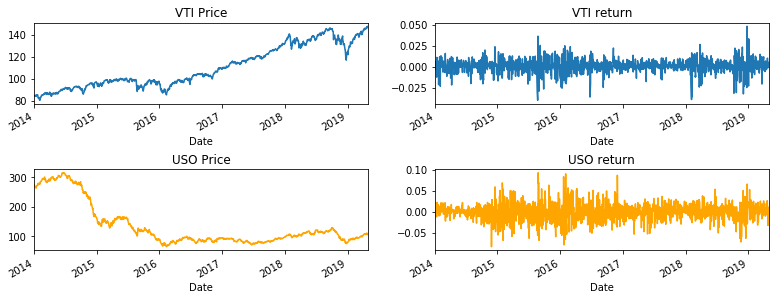

In [36]:
#開始畫圖
plt.subplots_adjust(top=1.5, bottom=0, left=0.3, right=2, hspace=0.8, wspace=0.2)
plt.subplot(3,2,1)   #2：共兩列，2：共兩行，1：目前在第一格子圖
plt.title("VTI Price")
data[tickers[0]].plot()
plt.subplot(3,2,2)
plt.title("VTI return")
returns[tickers[0]].plot()
# color="m"
plt.subplot(3,2,3)   #2：共兩列，2：共兩行，1：目前在第一格子圖
plt.title("USO Price")
data[tickers[15]].plot(color="orange")
plt.subplot(3,2,4)
plt.title("USO return")
returns[tickers[15]].plot(color="orange")

<b> Portfolio Return比較

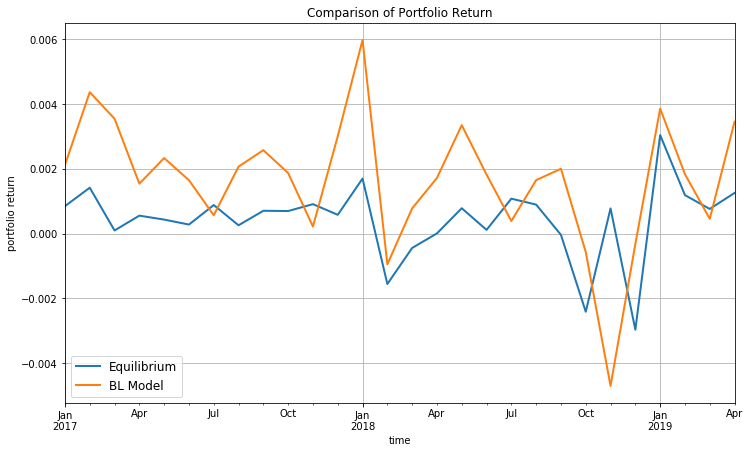

Equilibrium total return: 0.005073918537274045
BL Model total return: 0.01996998927752841


In [37]:
plt.figure(figsize=(12,7))

comparison_ret["Equilibrium"].plot(linewidth=2)
comparison_ret["BL Model"].plot(linewidth=2)

plt.grid(True)
plt.legend(loc='lower left', fontsize=12)
plt.xlabel('time')
plt.ylabel('portfolio return')
plt.title('Comparison of Portfolio Return')
plt.show()

print("Equilibrium total return:",eq_ret)
print("BL Model total return:", bl_ret)

<b> Portfolio Volatility 比較

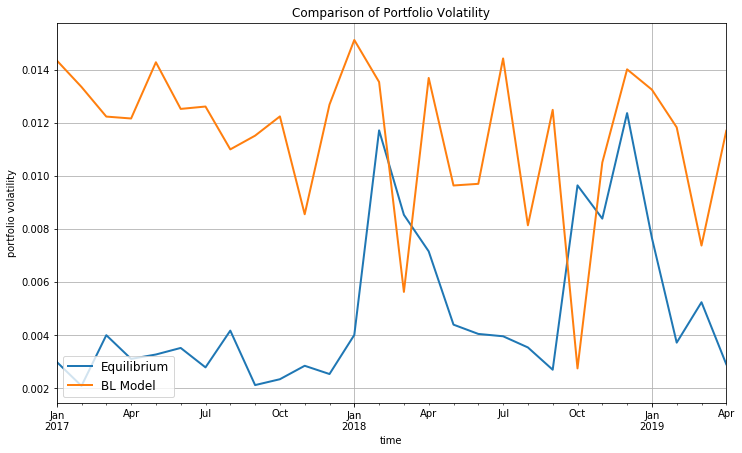

Equilibrium volatility: 0.004077624142311125
BL Model volatility: 0.0069073000579407545


In [38]:
plt.figure(figsize=(12,7))

comparison_vol["Equilibrium"].plot(linewidth=2)
comparison_vol["BL Model"].plot(linewidth=2)

plt.grid(True)
plt.legend(loc='lower left', fontsize=12)
plt.xlabel('time')
plt.ylabel('portfolio volatility')
plt.title('Comparison of Portfolio Volatility')
plt.show()

print("Equilibrium volatility:", eq_vol)
print("BL Model volatility:", bl_vol)

<b> Portfolio Sharpe Ratio比較

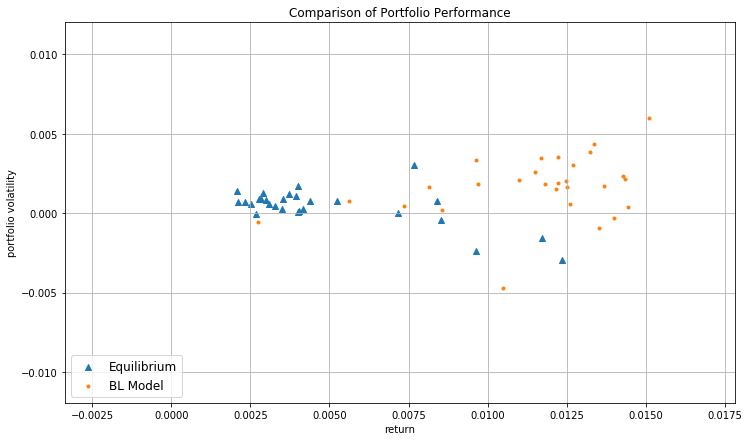

Equilibrium Sharpe: 1.2443320816710286
BL Model Sharpe: 2.8911425752484226


In [39]:
plt.figure(figsize=(12,7))

plt.scatter(comparison_vol["Equilibrium"], comparison_ret["Equilibrium"], label="Equilibrium",marker='^')
plt.scatter(comparison_vol["BL Model"], comparison_ret["BL Model"], label="BL Model",marker='.')

plt.grid(True)
plt.legend(loc='lower left', fontsize=12)
plt.xlabel('return')
plt.ylabel('portfolio volatility')
plt.title('Comparison of Portfolio Performance')
plt.show()

print("Equilibrium Sharpe:", eq_ret/eq_vol)
print("BL Model Sharpe:", bl_ret/bl_vol)